## Spectral clustering

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import pickle

import sys
import os
sys.path.append('../..')
from src.utils.directories import get_parent_directory
import numpy as np

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [2]:
parent_dir = get_parent_directory()
all_pkl_path = (os.path.join(parent_dir, "data/processed/ml_ready/merged_all.pkl"))

with open(all_pkl_path, 'rb') as f:
    data = pickle.load(f)

# clustering preparation

In [20]:
data = data[data['S'] >= 20]

max_points_per_latitude = 5

# Subsample the DataFrame
subsampled_df = data.groupby('latitude', group_keys=False).apply(lambda group: group.sample(n=min(max_points_per_latitude, len(group)), random_state=42))

# Reset the index of the subsampled DataFrame
subsampled_df.reset_index(drop=True, inplace=True)

In [21]:
data = subsampled_df

In [22]:
var_df = data[['S', 'T', 'log_eps', 'log_N2', 'dTdz', 'dSdz']]

# Keep the column names
column_names = var_df.columns

X = var_df

# Normalize the features using StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Add the column names back to the X_scaled array
X_scaled = pd.DataFrame(X_scaled, columns=column_names)

# Find optimal number of clusters

**Silhouette Score**:

The silhouette score is a metric used to evaluate the quality of clusters in a clustering analysis. It measures how similar each data point is to its own cluster (cohesion) compared to other clusters (separation). The silhouette score ranges from -1 to 1, where higher values indicate better clustering quality. The formula for calculating the silhouette score is as follows:

\[
\text{Silhouette Score} = \frac{b - a}{\max(a, b)}
\]

Where:
- \(a\) represents the average distance from a data point to other points in the same cluster (cohesion).
- \(b\) represents the minimum average distance from a data point to points in a different cluster (separation).

The silhouette score has the following interpretations:
- If the cohesion within the same cluster (\(a\)) is much smaller than the separation from other clusters (\(b\)), the silhouette score is close to 1, indicating that data points are well-matched to their own clusters.
- If the separation (\(b\)) is much smaller than the cohesion (\(a\)), the silhouette score is close to -1, suggesting that data points are poorly matched to their own clusters.
- A silhouette score near 0 indicates that a data point is near the decision boundary between two neighboring clusters.

In practice, a higher average silhouette score suggests better clustering, and the optimal number of clusters is often selected by comparing silhouette scores for different cluster numbers and choosing the number that maximizes the score. The silhouette score helps assess clustering quality and guide the selection of the appropriate number of clusters for the data.



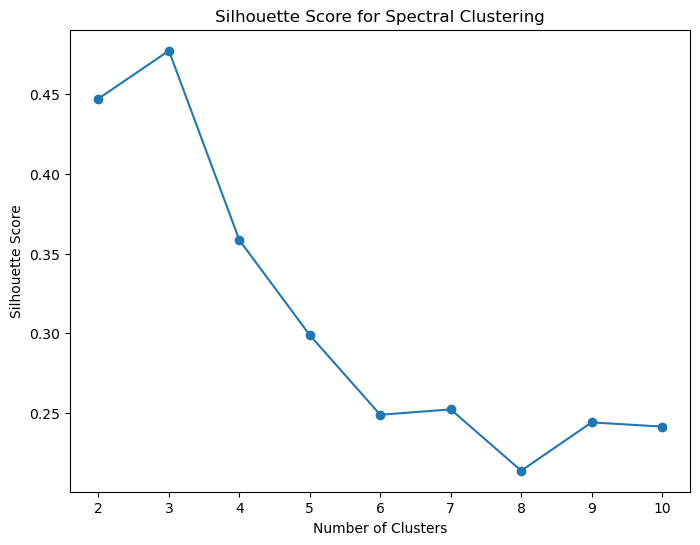

In [43]:
from sklearn.cluster import SpectralClustering
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# Create an array to store silhouette scores
silhouette_scores = []

# Define a range of cluster numbers to test
range_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10]

# Perform spectral clustering for different cluster numbers and record silhouette scores
for n_clusters in range_n_clusters:
    spectral_clustering = SpectralClustering(n_clusters=n_clusters, affinity='nearest_neighbors', n_neighbors=10)
    cluster_labels = spectral_clustering.fit_predict(X_scaled)
    
    # Calculate the silhouette score and record it
    silhouette_avg = silhouette_score(X_scaled, cluster_labels)
    silhouette_scores.append(silhouette_avg)

# Create a plot for the silhouette scores
plt.figure(figsize=(8, 6))
plt.plot(range_n_clusters, silhouette_scores, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Spectral Clustering')
plt.show()


## Perform spectral clustering

In [23]:
X = X_scaled

from sklearn.cluster import SpectralClustering

# Instantiate the Spectral Clustering model
n_clusters = 3  # The number of clusters to form
spectral_clustering = SpectralClustering(n_clusters=n_clusters, affinity='nearest_neighbors', n_neighbors=10)

# Fit the Spectral Clustering model to your scaled data
cluster_labels = spectral_clustering.fit_predict(X_scaled)

# Evaluate clusters

In [24]:
X_input = X[['S', 'T', 'log_eps', 'log_N2', 'dTdz', 'dSdz']]
# X_output = X[['Cluster']]

# Use the inverse_transform method to anti-scale X_scaled
transformed_df = pd.DataFrame(scaler.inverse_transform(X_input), columns=X_input.columns)

# Add cluster labels to the DataFrame
transformed_df['Cluster'] = spectral_clustering.labels_

# Round the values in the DataFrames to a specific number of decimal places
decimals = 4  # Adjust as needed
data_rounded = data.round(decimals)
transformed_df_rounded = transformed_df.round(decimals)

# Merge based on multiple columns (A and B)
merged_df = transformed_df_rounded.merge(data_rounded, on=['S', 'T', 'log_eps', 'log_N2', 'dSdz', 'dTdz'], how='left')

cluster_crisis_groups = merged_df.groupby(['Cluster', 'cruise']).size().unstack(fill_value=0)
cluster_crisis_groups

cruise,1,2,3,4,5,6,7,8,9,10,...,ABSO,ASCOS,Haakon Mosby,IPY Barneo 2007,IPY Barneo 2008,Mosaic,NICE-2015,Nansen Legacy 2018,Nansen Legacy 2019,TEA_COSI
Cluster,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,0,0,0,0,0,0,0,...,367,217,2,86,303,1092,118,2,3,1221
1,306,372,50,220,199,41,22,42,115,314,...,0,801,241,369,557,4093,2807,389,212,2
2,54,68,0,0,1,4,28,23,20,321,...,0,0,0,0,0,0,0,0,0,0


In [25]:
# Analyse cluster 0
cluster_0_data = merged_df[merged_df['Cluster'] == 0]
cluster_0_statistics = cluster_0_data.describe()
print(cluster_0_statistics)

                 S            T      log_eps       log_N2         dTdz  \
count  3418.000000  3418.000000  3418.000000  3418.000000  3418.000000   
mean     32.990936    -0.627378    -6.937310    -7.699865    -0.014707   
std       1.546471     2.075258     1.600015     3.994492     0.127824   
min      24.778300    -2.440900    -9.762000   -28.369100    -1.923500   
25%      32.145450    -1.769750    -8.507950   -10.876775    -0.004475   
50%      33.078200    -1.691850    -6.602100    -5.973450    -0.000100   
75%      34.196225    -0.472425    -5.809825    -4.348225     0.001200   
max      35.755400     7.864900    -0.016800    -2.148100     0.842800   

              dSdz  Cluster        depth      profile     latitude  \
count  3418.000000   3418.0  3411.000000  3411.000000  3411.000000   
mean      0.037884      0.0    64.218292   329.447595    82.304674   
std       0.130975      0.0    84.329591   380.514638     5.310269   
min      -0.139000      0.0     2.000000     0.000000

In [26]:
# Analyse cluster 1
cluster_0_data = merged_df[merged_df['Cluster'] == 1]
cluster_0_statistics = cluster_0_data.describe()
print(cluster_0_statistics)

                  S             T       log_eps        log_N2          dTdz  \
count  11699.000000  11699.000000  11699.000000  11699.000000  11699.000000   
mean      34.596339      1.122305     -9.081907     -5.030548      0.014768   
std        0.385837      2.116444      0.578072      0.802926      0.036667   
min       32.923000     -1.890000    -11.202600    -11.264200     -0.357800   
25%       34.357800     -0.647800     -9.315700     -5.611800      0.000200   
50%       34.716600      1.144000     -9.059300     -4.944600      0.004300   
75%       34.875650      2.350600     -8.779150     -4.412850      0.020500   
max       35.523000     14.037100     -5.460800     -2.770300      0.547000   

               dSdz  Cluster         depth        profile      latitude  \
count  11699.000000  11699.0  11699.000000   11699.000000  11699.000000   
mean       0.004839      1.0   -618.710661    4002.410091     65.402523   
std        0.009207      0.0   1717.853727   23592.511004     4

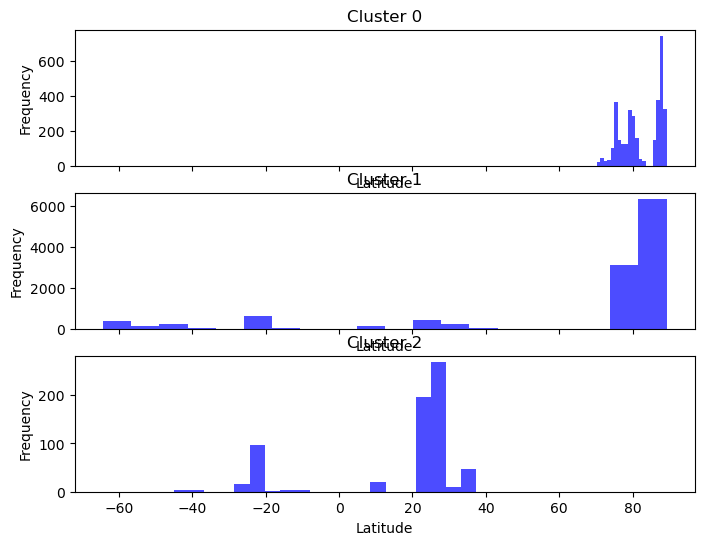

In [28]:
# Create a figure and axis for the histograms
fig, axes = plt.subplots(len(set(merged_df['Cluster'])), figsize=(8, 6), sharex=True)

for cluster_label, ax in zip(set(merged_df['Cluster']), axes):
    # Filter data points for the current cluster
    cluster_data = merged_df[merged_df['Cluster'] == cluster_label]
    
    # Plot a histogram of the latitude values for the current cluster
    ax.hist(cluster_data['latitude'], bins=20, alpha=0.7, color='blue')
    ax.set_title(f'Cluster {cluster_label}')
    ax.set_xlabel('Latitude')
    ax.set_ylabel('Frequency')

#plt.tight_layout()
plt.show()


## Plot clusters

The Silhouette Coefficient ranges from -1 to 1 and is calculated for each data point. Here's what the values mean:

Near +1: This indicates that the data point is well inside its own cluster and far from other clusters. A high Silhouette Coefficient suggests that the object is well matched to its own cluster and poorly matched to neighboring clusters.

Near 0: A value close to 0 suggests that the data point is on or very close to the decision boundary between two neighboring clusters. In this case, it could belong to either of the clusters or perhaps to a cluster in between.

Near -1: A value close to -1 indicates that the data point is probably assigned to the wrong cluster. It is far from its own cluster and very close to another cluster, suggesting a poor clustering solution.

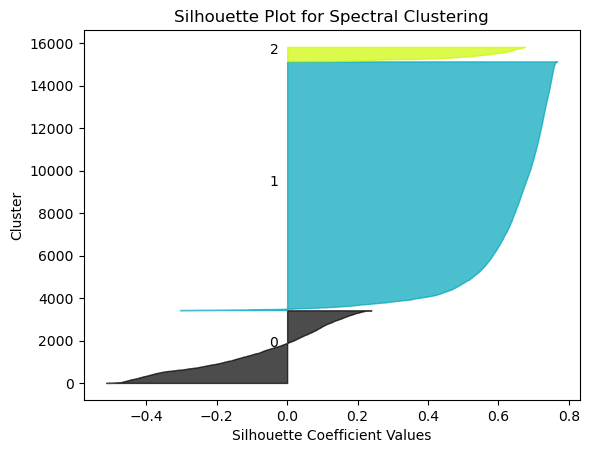

In [40]:
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np

silhouette_avg = silhouette_score(X, cluster_labels)
sample_silhouette_values = silhouette_samples(X, cluster_labels)

# Create a silhouette plot
y_lower = 10
for i in range(len(set(cluster_labels))):
    ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
    ith_cluster_silhouette_values.sort()
    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = cm.nipy_spectral(float(i) / len(set(cluster_labels)))
    plt.fill_betweenx(np.arange(y_lower, y_upper),
                      0, ith_cluster_silhouette_values,
                      facecolor=color, edgecolor=color, alpha=0.7)

    # Label the silhouette plots with their cluster numbers at the middle
    plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    y_lower = y_upper + 10  # Add 10 for the next plot

# Add a title and axis labels
plt.title("Silhouette Plot for Spectral Clustering")
plt.xlabel("Silhouette Coefficient Values")
plt.ylabel("Cluster")

# Show the plot
plt.show()

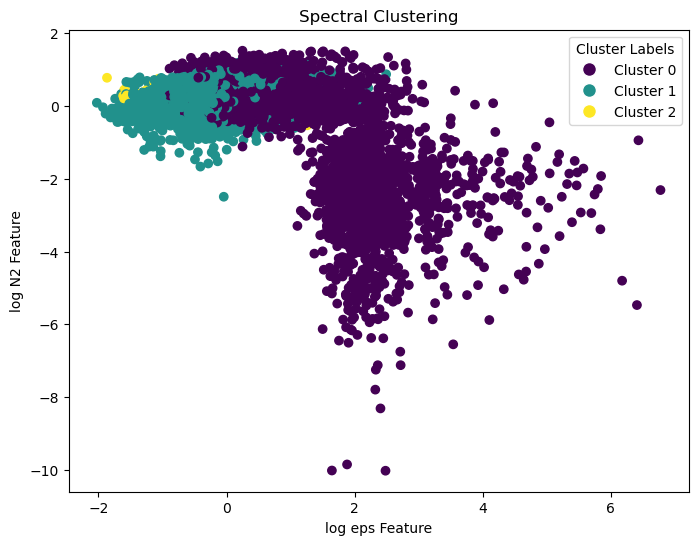

In [34]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# Assuming you have cluster_labels and X as specified in your previous code

# Select the two features (N2 and T) for plotting
feature_N = X['log_eps']
feature_T = X['log_N2']

# Create a scatter plot with cluster assignments
plt.figure(figsize=(8, 6))
scatter = plt.scatter(feature_N, feature_T, c=cluster_labels, cmap='viridis')

# Get unique cluster labels
unique_labels = list(set(cluster_labels))

# Create custom legend handles with corresponding labels and colors
legend_handles = [Line2D([0], [0], marker='o', color='w', markerfacecolor=scatter.to_rgba(label), markersize=10, label=f'Cluster {label}') for label in unique_labels]

# Set plot titles and labels
plt.title('Spectral Clustering')
plt.xlabel('log eps Feature')
plt.ylabel('log N2 Feature')

# Show the legend and the plot
plt.legend(handles=legend_handles, title="Cluster Labels")
plt.show()


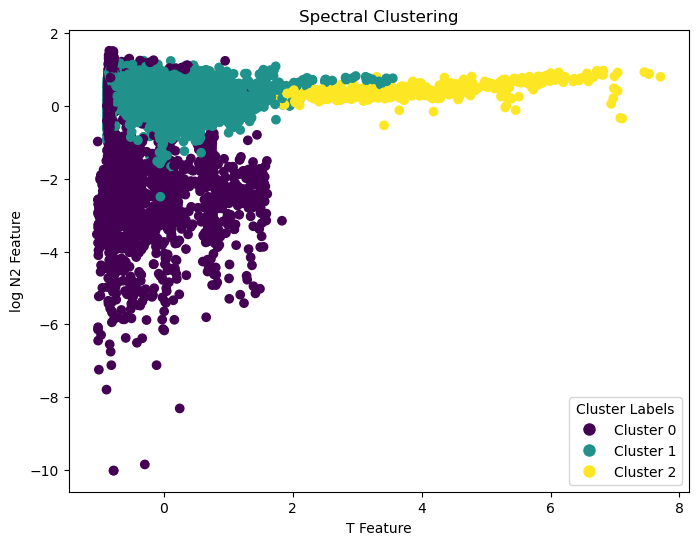

In [38]:
# Select the two features (N2 and T) for plotting
feature_N = X['T']
feature_T = X['log_N2']

# Create a scatter plot with cluster assignments
plt.figure(figsize=(8, 6))
scatter = plt.scatter(feature_N, feature_T, c=cluster_labels, cmap='viridis')

# Get unique cluster labels
unique_labels = list(set(cluster_labels))

# Create custom legend handles with corresponding labels and colors
legend_handles = [Line2D([0], [0], marker='o', color='w', markerfacecolor=scatter.to_rgba(label), markersize=10, label=f'Cluster {label}') for label in unique_labels]

# Set plot titles and labels
plt.title('Spectral Clustering')
plt.xlabel('T Feature')
plt.ylabel('log N2 Feature')

# Show the legend and the plot
plt.legend(handles=legend_handles, title="Cluster Labels")
plt.show()



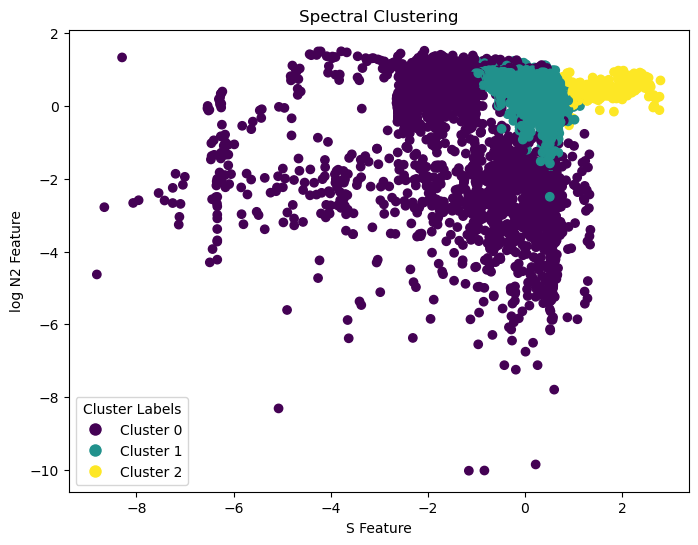

In [39]:
# Select the two features (N2 and T) for plotting
feature_N = X['S']
feature_T = X['log_N2']

# Create a scatter plot with cluster assignments
plt.figure(figsize=(8, 6))
scatter = plt.scatter(feature_N, feature_T, c=cluster_labels, cmap='viridis')

# Get unique cluster labels
unique_labels = list(set(cluster_labels))

# Create custom legend handles with corresponding labels and colors
legend_handles = [Line2D([0], [0], marker='o', color='w', markerfacecolor=scatter.to_rgba(label), markersize=10, label=f'Cluster {label}') for label in unique_labels]

# Set plot titles and labels
plt.title('Spectral Clustering')
plt.xlabel('S Feature')
plt.ylabel('log N2 Feature')

# Show the legend and the plot
plt.legend(handles=legend_handles, title="Cluster Labels")
plt.show()
